In [1]:
from rpy2.robjects.packages import importr
utils = importr("utils")
extremes = importr("extRemes")
ismev = importr("ismev")
eva = importr("eva")
gnFit = importr("gnFit")
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib.offsetbox import AnchoredText
from netCDF4 import num2date, date2num
statis = importr('stats')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import os
os.chdir(r'C:\Users\Pranjali\Downloads')
mask = xr.open_dataset("future.nc")

In [2]:
masked = mask['__xarray_dataarray_variable__']
ppt3 = masked.rolling(time=3).sum()


In [3]:
maxima3 = ppt3.groupby('time.year').max('time')

In [4]:
lon1=[]
lat1=[]
rlv3=[]
paramlist3=[]
for i in range(129):
    for j in range(135):

        maxima31 = maxima3.sel(lat=mask.lat[i],lon=mask.lon[j])
        params3 = {}    
        if(maxima31.values[1]>0):
            #RL2 = []
            block_maxima=maxima31.values[~np.isnan(maxima31.values)]
            try:
                gev_fit =  eva.gevrFit(block_maxima)
            except:
                pass
            MLE_est = list(gev_fit.rx2('par.ests'))

            #print(block_maxima)


            params3['location'] = MLE_est[0]

            params3['scale'] =  MLE_est[1] 

            params3['shape'] = MLE_est[2]

            if MLE_est[1]<0:
                MLE_est[1] = 0.01

            y = eva.rgevr(10000, 1, loc = MLE_est[0], scale = MLE_est[1], shape = MLE_est[2])

            sig_test = statis.ks_test(block_maxima, y)

            params3['p_val'] = sig_test.rx2('p.value')[0]
            paramlist3.append(params3)

    #print(params)
  


            if params3['p_val']>0.05:

                temp = eva.gevrRl(gev_fit, 100, method = "delta")

                RL3 = temp.rx2('Estimate')[0]
#n['RLV2'][i][j] = RL2

            else:
                params3['p_val'] = np.nan
                params3['location'] = np.nan
                params3['scale'] = np.nan
                params3['shape'] = np.nan
            #print(RL2,climate.lat.values[i],climate.lon.values[j])
            rlv3.append(RL3)
            lat1.append(mask.lat.values[i])
            lon1.append(mask.lon.values[j])
#n['RLV2'][i][j] = np.nan
#print(RL2)
        else:
            params3['p_val'] = np.nan
            params3['location'] = np.nan
            params3['scale'] = np.nan
            params3['shape'] = np.nan

<xarray.Dataset>
Dimensions:  (lat1: 117, lon1: 118)
Coordinates:
  * lat1     (lat1) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * lon1     (lon1) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25
Data variables:
    rlv3     (lat1, lon1) float64 nan nan nan nan nan ... nan nan nan nan nan


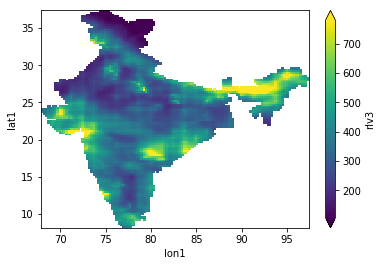

In [5]:
df2 = pd.DataFrame({'rlv3':rlv3,'lat1':lat1,'lon1':lon1})
ds2= df2.set_index(['lat1','lon1']).to_xarray()
print(ds2)
ds2['rlv3'].plot(robust=True)
plt.show()

In [6]:
ds2.to_netcdf(path=r'C:\Users\Pranjali\Downloads\ds2f.nc')